# Microsoft Movie Analysis

**Authors:** Kevin Culver

## Overview

The project analyzes various movie databases to provide tangible steps for Microsoft to take as it begins to create movie content. Analysis of these databases showed that certain characteristics of a movie, such as its genre, budget, or run time produced greater profit. Analysis also revealed common trends that top-grossing films share. These findings can be used by Microsoft to narrow down decisions on what types of films to produce and invest in.

## Business Problem

Creating a successful movie takes time, money, and risk. However, a company, like Microsoft, cannot predict how the movie will be received by it's audience. Therefore, the point of my analysis was to find what qualities are shared by high grossing films. to provide insight into what characteristics of movies have the greatest likelihood of monetary success. Using this data, I provide recommendations... 
***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

The data used in this project comes from three online movie databases - iMDB, The Numbers, and Box Office Mojo. Within these databases, each movie is identified by its title or movie id. When combined, these databases provide comprehensive information for each movie, including its rating, release date, budget, gross (both domestic and worldwide), genre and other characteristics. 


### Importing Relevant Modules and Datasets

In [3]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests

%matplotlib inline

In [4]:
#iMDB datasets
imdb_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
imdb_titles = pd.read_csv('zippedData/imdb.title.basics.csv.gz')

#The Numbers (movie budget dataset)
budget = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

### iMDB and The Numbers Datasets

#### iMDB Data
Two datasets imported from iMDB are: **imdb_ratings** and **imdb_titles**. 

The **imdb_ratings** database, provides the average ratings and number of votes for each movies.  The second database, **imdb_titles**, provides more info on each movie including it's title, runtime, start year, and genre. 


These two datasets can be easily joined since they share the unique movie identifier 'tconst'. In the cells below, the iMDB databases are joined using an inner join. 

In [5]:
#setting indexes to 'tconst' for each dataset to prep for inner join
imdb_titles.set_index('tconst', inplace=True)
imdb_ratings.set_index('tconst', inplace=True)

In [6]:
#joining dfs using inner join to get iMDB movies that contain both titles and ratings
imdb_titles_ratings = imdb_titles.join(imdb_ratings, how='inner')

imdb_titles_ratings.head(2)


,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
tconst,,,,,,,
tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43


At this point in the analysis, there are close to 74,000 entries. The start year's range from 2010-2019, but as we'll see this is column does not represent the movie's actual release date. 

#### The Numbers Data:

'The Numbers' dataset includes information on each movie's release date, title, budget, and total gross(both domestic and worldwide). The dataset contains 5782 entries.

In [7]:
budget.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


#### Merging Datasets

The two tables are merge using the each entry's movie title since this is the only category shared between the two datasets. After merging, the new 'movies_df' table has 2638 entries.

In [8]:
#merging the two tables (imdb + budget) using movie titles
movies_df = pd.merge(imdb_titles_ratings, budget, right_on='movie', left_on='original_title')
movies_df.head(2)

,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,"$45,000,000",$0,"$73,706"
1,The Overnight,The Overnight,2010,88.0,NaN,7.5,24,21,"Jun 19, 2015",The Overnight,"$200,000","$1,109,808","$1,165,996"


### Creating Top 2021 Movies Dataset Using Webscraping

Since the data from the tables above only includes movies up to 2019, I wanted to get more recent data. To do so, I webscraped data from the website boxofficemojo.com to from a table with the top 200 movies from 2021.

The data includes the movie's current rank, title, gross, release date, and studio.

In [9]:
html_page = requests.get("https://www.boxofficemojo.com/year/2021/?ref_=bo_lnav_hm_shrt")

soup = BeautifulSoup(html_page.content, 'html.parser')

In [10]:
#finding relevant division and creating container
table = soup.find('div', id='table')

#seperates all the relevant rows with movie data from table headers
table_rows = table.findAll('tr')[1:]

#length outputs 200 items, which corresponds to the 200 items on the website
len(table_rows)

200

In [11]:
#finding rank
rank = table_rows[0].find('td', class_="a-text-right mojo-header-column mojo-truncate mojo-field-type-rank mojo-sort-column").text

#finding title
title = table_rows[0].find('td', class_= "a-text-left mojo-field-type-release mojo-cell-wide").text

#finding amount grossed
gross = table_rows[0].find('td', class_ = "a-text-right mojo-field-type-money mojo-estimatable").text

#finding release date
release_date = table_rows[0].find('td', class_ = "a-text-left mojo-field-type-date a-nowrap").text

#finding studio
studio =  table_rows[0].find('td',class_ = "a-text-left mojo-field-type-studio").text.strip()


In [12]:
#Function to retrieve each row/movie from website
def get_movie_data(movie_table):
    movie_data = []
    for row in movie_table:
        rank = row.find('td', class_="a-text-right mojo-header-column mojo-truncate mojo-field-type-rank mojo-sort-column").text
        title = row.find('td', class_= "a-text-left mojo-field-type-release mojo-cell-wide").text
        gross = row.find('td', class_ = "a-text-right mojo-field-type-money mojo-estimatable").text
        release_date = row.find('td', class_ = "a-text-left mojo-field-type-date a-nowrap").text
        studio = row.find('td',class_ = "a-text-left mojo-field-type-studio").text.strip()
        
        movie_data.append({'Rank': rank, 'Title': title, 'Gross': gross, 
                           'Release Date': release_date, 'Studio': studio})
    return movie_data

In [13]:
movie_data = get_movie_data(table_rows)
rankings_2021_df = pd.DataFrame(movie_data)

rankings_2021_df.head()

,Rank,Title,Gross,Release Date,Studio
0,1,Shang-Chi and the Legend of the Ten Rings,"$223,734,907",Sep 3,Walt Disney Studios Motion Pictures
1,2,Venom: Let There Be Carnage,"$197,007,635",Oct 1,Sony Pictures Entertainment (SPE)
2,3,Black Widow,"$183,651,655",Jul 9,Walt Disney Studios Motion Pictures
3,4,F9: The Fast Saga,"$173,005,945",Jun 25,Universal Pictures
4,5,A Quiet Place Part II,"$160,072,261",May 28,Paramount Pictures


## Data Preparation


### Data Cleaning:

#### Changing Data Types:
<u> Steps Taken: </u>

 1. Any column that deals with total gross is converted from an object dtype into an integer dtype to make analysis easier.
 
2. A new column **'production_profit'** is created to measure the actual profit of each movie after accounting for the cost of budget.


3. A column, **'date_released'** is added that changes the release date to a datetime object to make analysis easier.


4. Finally, another column, **'release_month'** is created by separating the month name from the datetime object. This will make categorical analysis easier when creating data models.

In [14]:
#Function to tranform money columns into cleaned integers dtyes
def money_cleaner(df, column_name, new_col_name):
    df[new_col_name] = df[column_name].map(lambda x: x.replace('$', ''))
    df[new_col_name] = df[new_col_name].map(lambda x: x.replace(',', ''))
    df[new_col_name] = pd.to_numeric(df[new_col_name])
    
    return df[new_col_name]

In [15]:
#cleaning budget column
budget_clean = money_cleaner(movies_df, 'production_budget', 'budget_clean')
movies_df['budget_clean'] = budget_clean

#cleaning worldwide_gross column
worldwide_gross = money_cleaner(movies_df, 'worldwide_gross', 'ww_gross_clean')
movies_df['ww_gross_clean'] = worldwide_gross

movies_df.head()

,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_clean,ww_gross_clean
0,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,"$45,000,000",$0,"$73,706",45000000,73706
1,The Overnight,The Overnight,2010,88.0,NaN,7.5,24,21,"Jun 19, 2015",The Overnight,"$200,000","$1,109,808","$1,165,996",200000,1165996
2,The Overnight,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,21,"Jun 19, 2015",The Overnight,"$200,000","$1,109,808","$1,165,996",200000,1165996
3,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,17,"Mar 22, 2013",On the Road,"$25,000,000","$720,828","$9,313,302",25000000,9313302
4,On the Road,On the Road,2014,89.0,Drama,6.0,6,17,"Mar 22, 2013",On the Road,"$25,000,000","$720,828","$9,313,302",25000000,9313302


In [16]:
#Creates a production_profit column to determine how much profit each movie made
#after budget accounted for
movies_df['production_profit'] = movies_df['ww_gross_clean'] - movies_df['budget_clean']


In [17]:
#creating column with release date as datetime object
movies_df['date_released'] = pd.to_datetime(movies_df['release_date'])



In [18]:
#Creates release_month column and fills each row with the name of  its release 
#month
movies_df['release_month'] = movies_df['date_released'].dt.month_name()

#For readability in later analysis, only the firt 3 letters are retained for
#each month
movies_df['release_month'] = movies_df['release_month'].map(lambda x: x[:3])

***
The 'start_year' column is misleading. It does not always represent the actual release date. 
For example: "Action Jackson" came out in 1988, but the start date listed is 2014.

In the cell below, I correct the 'start_year' column by replacing it with the accurate year from 'release_date' column.

In [19]:
#replacing stary_year with correct year
movies_df['start_year'] = movies_df['release_date'].map(lambda x: x[-4:])

#The last step is to convert the column into an int64 dtype
movies_df['start_year'] = pd.to_numeric(movies_df['start_year'])


#### Dropping Unnecessary Columns
The titles dropped below are not used in later analysis, so they are dropped to make for a cleaner, more readable table.

In [20]:
movies_df.drop(labels=['original_title', 'id', 'movie', 'release_date', 
                       'production_budget', 'domestic_gross', 
                       'worldwide_gross'], axis=1, inplace=True)

#### Removing Duplicates and Null Values

There are 5 items without genres and 106 items without runtime with 2638 items in total. Since there are only 5 without genre, these items are dropped. 

Runtime is not used in this analysis, so no action is taken for these null values.


In [21]:
movies_df.head()

,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,budget_clean,ww_gross_clean,production_profit,date_released,release_month
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,45000000,73706,-44926294,2012-12-31,Dec
1,The Overnight,2015,88.0,NaN,7.5,24,200000,1165996,965996,2015-06-19,Jun
2,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,200000,1165996,965996,2015-06-19,Jun
3,On the Road,2013,124.0,"Adventure,Drama,Romance",6.1,37886,25000000,9313302,-15686698,2013-03-22,Mar
4,On the Road,2013,89.0,Drama,6.0,6,25000000,9313302,-15686698,2013-03-22,Mar


In [22]:
movies_df.dropna(subset=['genres'], inplace=True)

In [23]:
movies_df.duplicated(subset='primary_title').sum()

541

There are 541 duplicate titles in the dataset that need to be dropped. After being dropped the total number of entries in the table is 2092. 


In [24]:
movies_df.drop_duplicates(keep='first', subset='primary_title', inplace=True)

#Sucessfully dropped duplicate entries
movies_df.shape

(2092, 11)

### Separating Genres and Creating New Data Frame
Each movie can have multiple genre designations. However, these designations are clumped together in a list and need to be separated for better, more accurate analysis. Below, a new data frame is created that creates a row for each genre designation for each movie.  

In [25]:
#Splits/seperates each genre category for each movie/row
movies_df['genres_list'] = movies_df['genres'].map(lambda x: x.split(','))
movies_df.head(2)

#Creates new df with each genre category represented in a row
genres_df = movies_df.explode('genres_list')
genres_df.head(5)

,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,budget_clean,ww_gross_clean,production_profit,date_released,release_month,genres_list
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,45000000,73706,-44926294,2012-12-31,Dec,Action
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,45000000,73706,-44926294,2012-12-31,Dec,Animation
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,45000000,73706,-44926294,2012-12-31,Dec,Comedy
2,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,200000,1165996,965996,2015-06-19,Jun,Comedy
2,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,200000,1165996,965996,2015-06-19,Jun,Mystery


In [ ]:
movies_df.head(2)

## Data Modeling and Evaluation
The organized data above has several categories that can be used for analysis. Since Microsoft is interested in creating successful, profitable movies, each relevant category is modeled and related to production profit.  

The four categories used for modeling are: genre type, release month, movie budget, and movie rating. Each category is first charted and then evaluated. 

### Genre and Profitability: 

Both genre type and release month provide clear categories that can be charted and analyzed easily. By charting these categories using barplots, it will become apparent if any genres or times of release are more profitable than others. If clear patterns become evident, these patterns can inform Microsoft's business decisions for what type of films to make or when to release films.

In [35]:
# Orders the genres from most profitable to least. To be used in sns barplot
genre_means = genres_df.groupby('genres_list').mean()['production_profit']\
                                    .sort_values(ascending=False)
genre_means

genres_list
Animation      2.363154e+08
Adventure      2.171770e+08
Sci-Fi         1.885434e+08
Action         1.350282e+08
Fantasy        1.343454e+08
Musical        1.232874e+08
Family         1.052106e+08
Comedy         7.754861e+07
Thriller       5.478457e+07
Mystery        5.302520e+07
Music          4.891215e+07
Sport          4.813030e+07
Biography      4.803369e+07
Horror         3.756365e+07
Crime          3.734562e+07
Drama          3.705325e+07
Romance        3.674531e+07
History        3.246015e+07
Western        3.152104e+07
War            2.568817e+07
Documentary    2.461319e+07
Name: production_profit, dtype: float64

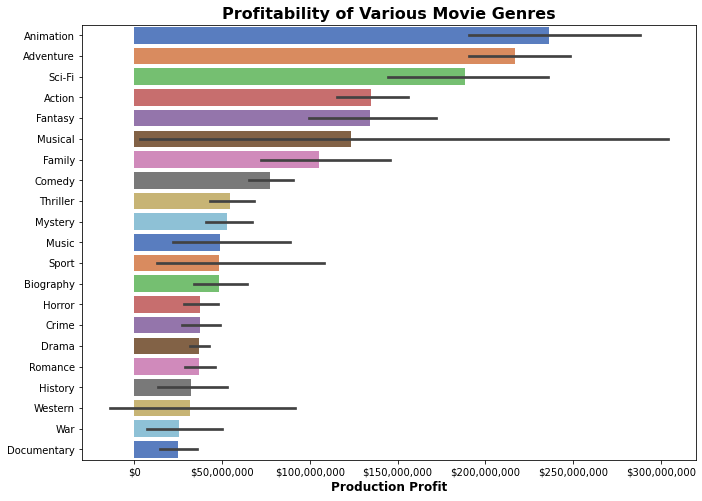

In [27]:
ax = sns.barplot(data=genres_df, y='genres_list', x='production_profit', 
                 order=genre_means.index, palette='muted')


ax.get_figure().set_size_inches((11, 8))

##?? HOW to order by profit rather than genre category?? 
ax.set_xlabel('Production Profit', fontsize=12, fontweight='bold')
ax.xaxis.set_major_formatter("${x:,.0f}")

##?? HOW to rotate xlabels?

ax.set_ylabel(ylabel=None)

ax.set_title('Profitability of Various Movie Genres', fontsize=16, fontweight='bold')

plt.savefig('./images/genre_profit.png', facecolor='white');

### Genre Evaluation: 

It is evident that some genres are much more profitable than others. For example, the Animation genre is nearly ten times more profitable than the Documentary genre.

**The most profitable genre categories are:** 
1. Animation ($236 million)  

2. Adventure ($217 million)

3. Sci-fi ($189 million)

However, the next best performing category is harder to determine with the *action*, *fantasy*, and *musical* genres earning around $125-135 million.

**The least profitable genres are:**
1. Documentary ($24.6 million)

2. War ($25.6 million)

There is also a clump of genre categories that perform similarly earning between $31 and 37 million. These genres (from least profitable to most): *history*, *romance*, *drama*, *crime*, and *horror*.


### Release Month and Profitability

In [36]:
#Orders months by profit. Order will be used in sns plot below.
month_means = movies_df.groupby('release_month').mean()['production_profit']\
                                           .sort_values(ascending=False)
month_means

release_month
Jun    1.344192e+08
May    1.122625e+08
Jul    1.106925e+08
Nov    1.103317e+08
Mar    7.703935e+07
Dec    6.812520e+07
Feb    6.578280e+07
Apr    5.688355e+07
Aug    4.554133e+07
Oct    4.089157e+07
Jan    3.961325e+07
Sep    3.677364e+07
Name: production_profit, dtype: float64

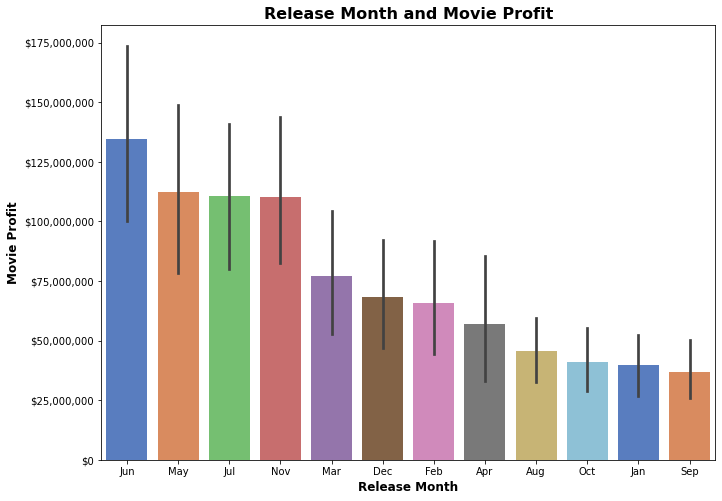

In [29]:
#Creating seaborn barplot

fig, ax = plt.subplots(figsize=(11,8))

ax = sns.barplot(data=movies_df, x='release_month', y='production_profit',
           order=month_means.index, palette='muted')

ax.set_xlabel('Release Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Movie Profit', fontsize=12, fontweight='bold')
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_title('Release Month and Movie Profit', fontsize=16, fontweight='bold');

### Release Month Evaluation:

**The top three most profitable release months are:**
1. June ($134 million)

2. May ($112 milion)

3. July ($111 million)

All three of these months are during the summer months, indicating that people go out to see movies more in the summer than in the fall and winter.

The fourth most profitable month was **November**. Films are often released during the holiday season (around Thanksgiving) and many Americans have a tradition of going to the movies on Thanksgiving. This could also be a good month to release a movie

**The least profitable release months:**
1. September ($37 million)

2. January ($40 million)

3. October ($41 million)

4. August ($45 million)

Three out of the four lowest profit months occur in fall (Aug-Oct), making the fall one of the worst times to release a film. 

### The Impact of Budget Size on Movie Profit

The basic question this model seeks to answer is: do movies with higher budgets produce higher profit? In other words, is budget positively related to profit? In this section, descriptive statistics are also provided to gain insight into the average and median budgets for movies. By answering these questions, Microsoft can plan their budgeting for each film within a specified range. 

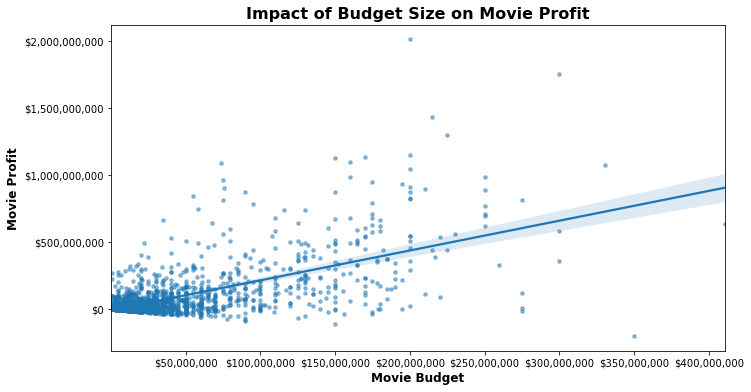

In [39]:
fig, ax = plt.subplots(figsize=(11,6))


#Average movie profit scatterplot
sns.regplot(data=movies_df, x='budget_clean', y='production_profit', 
                     scatter_kws = dict(alpha=0.5, s=12))

ax.set_xlabel('Movie Budget', fontsize=12, fontweight='bold')
ax.xaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel('Movie Profit', fontsize=12, fontweight='bold')
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_title('Impact of Budget Size on Movie Profit', fontsize=16, fontweight='bold');

In [33]:
movies_df['budget_clean'].describe()

##Mean budget: $36.7 million
##Median budget: $18 million
##Top 75% of films: $45 million 

count    2.092000e+03
mean     3.669263e+07
std      5.024722e+07
min      1.400000e+03
25%      5.000000e+06
50%      1.800000e+07
75%      4.500000e+07
max      4.106000e+08
Name: budget_clean, dtype: float64

### Evaluation of Budget Size: 

There is a relatively strong correlation between movie budget size and profit. This indicates that movies with a higher budget tend to perform better in the box office. Several factors could contribute to this (e.g., better marketing, higher quality producers and actors, better visual effects). Further research could look into the budget of successful movies to see how to best allocate resources. 

**Descriptive Stats:**
- Mean budget: $37 million 

- The median budget: $18 million 

- 75th percentile: $45 million



### The Impact of Ratings on Profit

Finally, movie rating was considered to see if higher rated movies earn more profit. By modeling this question, Microsoft can gain set a minimum rating to aim for as they create movies. Further research could also be conducted in what causes movies to be rated higher than others. 

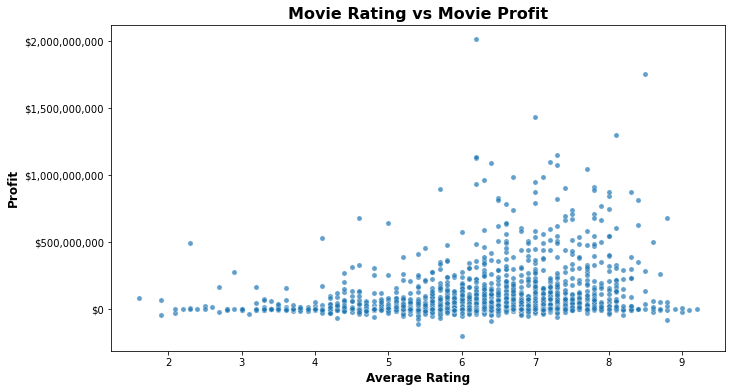

In [42]:
#Plotting scatterplot of movies rating and their profit
fig, ax = plt.subplots(figsize=(11,6))
plt.xticks()
ax = sns.scatterplot(data=movies_df,
                  y='production_profit', x='averagerating', palette='muted',
                     alpha=0.7, s=27)

ax.set_xlabel('Average Rating', fontsize=12, fontweight='bold')

ax.set_ylabel('Profit', fontsize=12, fontweight='bold')
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_title("Movie Rating vs Movie Profit", fontsize=16, fontweight='bold');

In [37]:
movies_df['averagerating'].describe()

count    2092.000000
mean        6.234034
std         1.154895
min         1.600000
25%         5.600000
50%         6.400000
75%         7.000000
max         9.200000
Name: averagerating, dtype: float64

In [ ]:
### 

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***